In [1]:
import os
print(os.listdir("../input"))

['glovedataset', 'donor-choose']


# DonorsChoose - TSNE Assignement

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

# 1. About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
# why use matplotlib inline? https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

#stop words or generally less important words 
from nltk.corpus import stopwords

#snow ball stemmer is powerfull than potter stemmer
from nltk.stem import PorterStemmer

#wordLemmatizer is breaking setence into multiple words
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm


#all drawings are based on plotly not on matplotlib
from plotly import plotly
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from collections import Counter

from scipy.stats import norm
from sklearn.neighbors import KernelDensity

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## 1.1. Reading Data

In [3]:
project_data = pd.read_csv('../input/donor-choose/train_data.csv')
resource_data = pd.read_csv('../input/donor-choose/resources.csv')

# 2. Exploratory Data Analysis

## 2. 0. Understanding data

In [4]:
print("Shape of train data", project_data.shape)
print("=" * 50)
print("The attributes of data :", project_data.columns.values)

Shape of train data (109248, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train resource data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train resource data (1541272, 4)
['id' 'description' 'quantity' 'price']


id   ...     price
0  p233245   ...    149.00
1  p069063   ...     14.95

[2 rows x 4 columns]

**summary:**

*TrainData:*
<ul>
    <li>It has 109248 data points</li>
    <li>Each data point has 17 data variables</li>
</ul>
*resources data:*
<ul>
    <li>It has 1541272 data points</li>
    <li>Each data point has 4 data variables</li>
</ul>

=======================================

**removing duplicate documents from tain dataset**

In [6]:
# remove any duplicate rows
ref_project_data = project_data.drop_duplicates(['project_title','teacher_id','project_submitted_datetime'],keep='first', inplace=False)
print(ref_project_data.shape)

(109248, 17)


=> It seems original data does not have duplicates


=============================================

## 2.1. Number of Projects Approved Vs Not Approved

In [7]:

#https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.value_counts.html
y_value_counts = project_data['project_is_approved'].value_counts()
#print(y_value_counts)
print("Number of projects thar are approved for funding ", y_value_counts[1], ", \
(", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", \
(", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

data_for_pie = [y_value_counts[1], y_value_counts[0]]
print(data_for_pie)
labels_for_pie = ['approved', 'rejected']


trace = go.Pie(values = data_for_pie, labels = labels_for_pie, hole = .4)
iplot([trace], filename = 'Approved vs Rejected')

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)
[92706, 16542]


### summary:
* 84.9 percent projects are approved, that means a project submitted has more change of approval.

## 2.2. Univariant Analysis

### 2.2.1. teacher prefix:

<b><el>Bar graph generic function for univariant analysis</el></b>

In [8]:
groupCounts  = project_data.groupby(['teacher_prefix']);
print(groupCounts.size().loc['Mr.'])
print(groupCounts.size().loc['Mrs.'])

10648
57269


In [9]:
#univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)



def univariantPlotsPlotly(column1, title, column2 = 'project_is_approved', top = False):
    groupCounts  = project_data.groupby([column1]);
    groupCountsPos = project_data.loc[project_data['project_is_approved'] == 1].groupby([column1])
    groupCountsNeg = project_data.loc[project_data['project_is_approved'] == 0].groupby([column1])
    #print(groupCounts.size())
    #type(groupCounts.size())
    groupCountLists = list(groupCounts.size().index.values)
    tempdata1 = []
    tempdata0 = []
    x_labels = []
    AvgMtx = []
    partOfTotal = []
    for i in groupCountLists:
        x_labels.append(i)
        try:
            tempdata1.append(groupCountsPos.size().loc[i])
        except KeyError:
            tempdata1.append(0)
        try:
            tempdata0.append(groupCountsNeg.size().loc[i])
        except KeyError:
            tempdata0.append(0)
    total = sum(tempdata0) + sum(tempdata1)
    print(len(tempdata0))
    print(len(tempdata1))
        
    for z in range(len(tempdata1)):
        avg = (tempdata1[z])/(tempdata1[z] + tempdata0[z])
        totalpart = (tempdata1[z] + tempdata0[z]) / total
        AvgMtx.append(avg)
        partOfTotal.append(totalpart)
    trace1 = pd.Series(tempdata1, index = x_labels)
    tempdata0 = np.add(tempdata0, tempdata1)
    trace2 = pd.Series(tempdata0, index = x_labels)
    trace3 = pd.Series(AvgMtx, index = x_labels)
    trace4 = pd.Series(partOfTotal, index = x_labels)
    return createDataFrame(trace1, trace2, trace3, trace4, title, top)
    
def createDataFrame(trace1, trace2, trace3, trace4, title, top = True):
    tempdf = pd.DataFrame({'pos': trace1, 'total': trace2, 'avg': trace3, 'npart': trace4})
    tempdf = tempdf.sort_values(by='npart', ascending = False)
    print(tempdf.head())
    if top:
        tempdf_short = tempdf.head(20)
        tempdf_short[['total', 'pos']].iplot(
            kind='bar',
            barmode='overlay',
            xTitle='categeory',
            yTitle='no of application',
            title=title)
    else:
        tempdf[['total', 'pos']].iplot(
            kind='bar',
            barmode='overlay',
            xTitle='categeory',
            yTitle='no of application',
            title=title)
    return tempdf

    
df = univariantPlotsPlotly(column1 = 'teacher_prefix', title = 'Number of Projects Approved vs Rejected: teacher_prefix')

5
5
           pos  total       avg     npart
Mrs.     48997  57269  0.855559  0.524225
Ms.      32860  38955  0.843537  0.356584
Mr.       8960  10648  0.841473  0.097469
Teacher   1877   2360  0.795339  0.021603
Dr.          9     13  0.692308  0.000119


**summary:**
<ul>
    <li>Highest number of assignements are submitted by persons with Mrs as prefix Number of Female applicants are significantly higher</li>
    <li>Highest approval rate is also for persons with Mrs prefix</li>
    <li>Number of submission by persons with Mrs, Ms are significantly higher than others prefixes, with former top the list</li>
</ul>

============================================================================================================

### 2.2.3. Univariant Analysis: School_state

In [10]:
df = univariantPlotsPlotly('school_state', title = 'Number of Projects Approved vs Rejected: school_state')
df = df.sort_values(by='avg', ascending = False)
print('First 5 states with Highest approval')
print(df.head(5))
print('Last 5 states with Highest approval')
print(df.tail(5))
print('mean of average acceptence of all states ' + str(df['avg'].mean()))

51
51
      pos  total       avg     npart
CA  13205  15388  0.858136  0.140854
TX   6014   7396  0.813142  0.067699
NY   6291   7318  0.859661  0.066985
FL   5144   6185  0.831690  0.056614
NC   4353   5091  0.855038  0.046600


First 5 states with Highest approval
     pos  total       avg     npart
DE   308    343  0.897959  0.003140
ND   127    143  0.888112  0.001309
WA  2045   2334  0.876178  0.021364
OH  2159   2467  0.875152  0.022582
NH   304    348  0.873563  0.003185
Last 5 states with Highest approval
     pos  total       avg     npart
LA  1990   2394  0.831245  0.021913
MT   200    245  0.816327  0.002243
TX  6014   7396  0.813142  0.067699
DC   414    516  0.802326  0.004723
VT    64     80  0.800000  0.000732
mean of average acceptence of all states 0.8481205441795778


#### Summary:
* Highest number of application sent by CA followed by TX, NY, FL
* average of average acceptace of all states is around 84.81%
* least acceptance is 80%, it means there is evidence of bias over states 

**Heat map for school_state**

In [11]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='us-map-heat-map')

#### Summary:
<ul>
    <li> 'CA' has the highest number of submissions</li>
</ul>

### 2.2.4.Univariate Analysis: project_grade_category


In [12]:
df = univariantPlotsPlotly('project_grade_category', 
                           title = 'Number of projects approved vs rejected: project grade category')

4
4
                 pos  total       avg     npart
Grades PreK-2  37536  44225  0.848751  0.404813
Grades 3-5     31729  37137  0.854377  0.339933
Grades 6-8     14258  16923  0.842522  0.154904
Grades 9-12     9183  10963  0.837636  0.100350


#### summary:
* no of application for Grades prek-2 and Grades 3-5 are significantly higher than others.
* As Grade of students increasses no of applications decreasses. That implies pre school and Elementary school students are benefitting from the donations more than others.
### 2.2.5.Univariate Analysis: project_subject_categories

In [13]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

catogories_series = pd.Series(cat_list)
project_data['catogories'] = catogories_series
df = univariantPlotsPlotly('catogories',
                           title='Number of Projects approved vs Rejected: project subject categories')
short_df = df.head(20)
trace1 = go.Bar(y= short_df['total'].tolist(), x = short_df.index.tolist(), name = 'total subissions')
trace2 = go.Bar(y= short_df['pos'].tolist(), x = short_df.index.tolist(), name = 'accepted subissions')
data = [trace1, trace2]
layout = go.Layout(
    barmode = 'overlay',
    xaxis= dict(title = 'category'),
    yaxis= go.layout.YAxis(title = 'number of submissions', automargin = True),
    title='Number of Projects approved vs Rejected: project subject categories'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

print(df.sort_values(by = 'avg', ascending = False).tail())

51
51
                                  pos  total       avg     npart
Literacy_Language               20520  23655  0.867470  0.216526
Math_Science                    13991  17072  0.819529  0.156268
Literacy_Language Math_Science  12725  14636  0.869432  0.133970
Health_Sports                    8640  10177  0.848973  0.093155
Music_Arts                       4429   5180  0.855019  0.047415


                                   pos  total       avg     npart
Music_Arts AppliedLearning           7     10  0.700000  0.000092
Music_Arts Health_Sports            13     19  0.684211  0.000174
Math_Science Warmth Care_Hunger      6     11  0.545455  0.000101
Music_Arts Warmth Care_Hunger        1      2  0.500000  0.000018
History_Civics Warmth Care_Hunger    0      1  0.000000  0.000009


In [14]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in cat_list:
    my_counter.update(word.split())
print(my_counter)

Counter({'Literacy_Language': 52239, 'Math_Science': 41421, 'Health_Sports': 14223, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_Arts': 10293, 'History_Civics': 5914, 'Warmth': 1388, 'Care_Hunger': 1388})


In [15]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

trace1 = go.Bar(y= list(sorted_cat_dict.values()), x = list(sorted_cat_dict.keys()), name = 'total subissions')
data = [trace1]
layout = go.Layout(
    xaxis= dict(title = 'category'),
    yaxis= go.layout.YAxis(title = 'number of submissions', automargin = True),
    title = 'total submissions by keyword'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [16]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


##### summary:
* Literacy_language category has more number of submissions followed by math_science
* Literacy_Language AppliedLearning has zero accepted applications
* Total categories by subject can be brought down to 9

### 2.2.5. Univariate Analysis: project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
print(len(sub_cat_list))

sub_catogories_series = pd.Series(sub_cat_list)
project_data['sub_catogories'] = sub_catogories_series

df = univariantPlotsPlotly('sub_catogories',
                           title='Number of Projects approved vs Rejected: project subject sub categories')
short_df = df.head(20)
trace1 = go.Bar(y= short_df['total'].tolist(), x = short_df.index.tolist(), name = 'total subissions')
trace2 = go.Bar(y= short_df['pos'].tolist(), x = short_df.index.tolist(), name = 'accepted subissions')
data = [trace1, trace2]
layout = go.Layout(
    barmode = 'overlay',
    xaxis= dict(title = 'sub category'),
    yaxis= go.layout.YAxis(title = 'number of submissions', automargin = True),
    title='Number of Projects approved vs Rejected: project subject categories'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)
print('least approved 5')
print(df.sort_values(by = 'avg', ascending = False).tail())
print('\n top approved 5')
print(df.sort_values(by = 'avg', ascending = False).head())

109248
401
401
                                 pos  total       avg     npart
Literacy                        8371   9486  0.882458  0.086830
Literacy Mathematics            7260   8325  0.872072  0.076203
Literature_Writing Mathematics  5140   5923  0.867803  0.054216
Literacy Literature_Writing     4823   5571  0.865733  0.050994
Mathematics                     4385   5379  0.815207  0.049237


least approved 5
                                      pos  total       avg     npart
Other PerformingArts                    1      3  0.333333  0.000027
Mathematics Warmth Care_Hunger          1      3  0.333333  0.000027
CommunityService NutritionEducation     1      4  0.250000  0.000037
ESL Economics                           0      1  0.000000  0.000009
History_Geography Warmth Care_Hunger    0      1  0.000000  0.000009

 top approved 5
                                   pos  total  avg     npart
Other Warmth Care_Hunger             1      1  1.0  0.000009
ESL NutritionEducation               3      3  1.0  0.000027
Civics_Government Health_Wellness    2      2  1.0  0.000018
Extracurricular ForeignLanguages     2      2  1.0  0.000018
ForeignLanguages Gym_Fitness         2      2  1.0  0.000018


In [18]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in sub_cat_list:
    my_counter.update(word.split())
print(my_counter)

Counter({'Literacy': 33700, 'Mathematics': 28074, 'Literature_Writing': 22179, 'SpecialNeeds': 13642, 'AppliedSciences': 10816, 'Health_Wellness': 10234, 'VisualArts': 6278, 'EnvironmentalScience': 5591, 'Gym_Fitness': 4509, 'ESL': 4367, 'EarlyDevelopment': 4254, 'Health_LifeScience': 4235, 'History_Geography': 3171, 'Music': 3145, 'College_CareerPrep': 2568, 'Other': 2372, 'TeamSports': 2192, 'CharacterEducation': 2065, 'PerformingArts': 1961, 'SocialSciences': 1920, 'Warmth': 1388, 'Care_Hunger': 1388, 'NutritionEducation': 1355, 'ForeignLanguages': 890, 'Civics_Government': 815, 'Extracurricular': 810, 'ParentInvolvement': 677, 'FinancialLiteracy': 568, 'CommunityService': 441, 'Economics': 269})


In [19]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

trace1 = go.Bar(y= list(sorted_sub_cat_dict.values()), x = list(sorted_sub_cat_dict.keys()), name = 'total subissions')
data = [trace1]
layout = go.Layout(
    xaxis= dict(title = 'sub category'),
    yaxis= go.layout.YAxis(title = 'number of submissions', automargin = True),
    title = 'total submissions by keyword'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [20]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


#### summary:
* sub categroy follows almost same trend as the category one
* one interesting observation is approval rate for the group `History_Geography Warmth Care_Hunger` is low where as for the group `warmth Care_Hunger` is high, that implies if the tags of categories can not be related to each other then approval rate is low 

### 2.2.6. Univariate Analysis: Text features (Title)


In [21]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))

print(word_dict)
trace1 = go.Bar(y= list(word_dict.values()), x = list(word_dict.keys()), name = 'total subissions')
data = [trace1]
layout = go.Layout(
    xaxis= dict(title = 'title'),
    yaxis= go.layout.YAxis(title = 'number of submissions'),
    title = 'total submissions by title'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

{13: 1, 12: 11, 11: 30, 1: 31, 10: 3968, 9: 5383, 8: 7289, 2: 8733, 7: 10631, 6: 14824, 3: 18691, 5: 19677, 4: 19979}


#### summary:
* most number of submissions between 3 and 6

In [22]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values
rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

In [23]:
trace0 = go.Box(
    y = approved_title_word_count,
    name = 'approved',
    marker=dict(
        color='rgb(255,69,0)',
    ),
    boxmean='sd'
)
trace1 = go.Box(
    y = rejected_title_word_count,
    name = 'rejected',
    marker=dict(
        color='rgb(10, 140, 208)',
    ),
    boxmean='sd'
)
data = [trace0, trace1]

layout = go.Layout(
        title = 'box plots for approved and rejected word counts of title',
        yaxis = dict( title = 'number of words in title')
    )
fig = go.Figure(data = data, layout = layout)
iplot(fig)

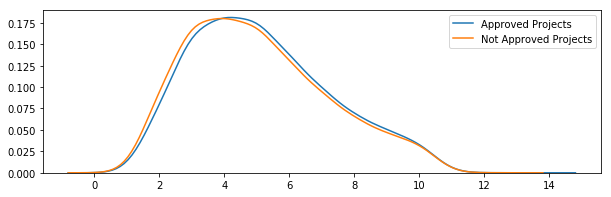

In [24]:
#kernel density estimation plot
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

#### summar:
* On an average rejected has lesser number of words than accepted, but both rejected and approved has huge area of overlap that we can't really conclude any relationship between number of words and approval status.

### 2.2.7. Univariate Analysis: Text features (Project Essay's)

In [25]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [26]:
approved_essay_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_essay_word_count = approved_essay_word_count.values

rejected_essay_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_essay_word_count = rejected_essay_word_count.values

In [27]:
trace0 = go.Box(
    y = approved_essay_word_count,
    name = 'approved',
    marker=dict(
        color='rgb(255,69,0)',
    ),
    boxmean='sd'
)
trace1 = go.Box(
    y = rejected_essay_word_count,
    name = 'rejected',
    marker=dict(
        color='rgb(10, 140, 208)',
    ),
    boxmean='sd'
)
data = [trace0, trace1]

layout = go.Layout(
        title = 'box plots for approved and rejected word counts of essays',
        yaxis = dict( title = 'number of words in essay')
    )
fig = go.Figure(data = data, layout = layout)
iplot(fig)

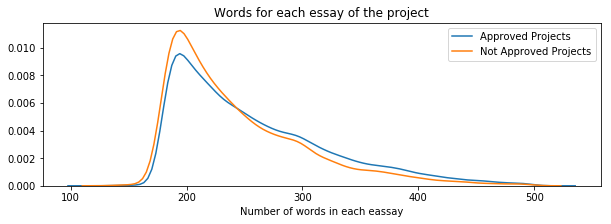

In [28]:
plt.figure(figsize=(10,3))
sns.distplot(approved_essay_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_essay_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

#### summary:
* both approved and rejected word count for essays does not have pattern to categorise but on an average approved projects has more number of projects

### 2.2.8. Univariate Analysis: Cost per project

In [29]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id   ...     price
0  p233245   ...    149.00
1  p069063   ...     14.95

[2 rows x 4 columns]

In [30]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [31]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [32]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

In [33]:
trace0 = go.Box(
    y = approved_price,
    name = 'approved',
    marker=dict(
        color='rgb(255,69,0)',
    ),
    boxmean='sd'
)
trace1 = go.Box(
    y = rejected_price,
    name = 'rejected',
    marker=dict(
        color='rgb(10, 140, 208)',
    ),
    boxmean='sd'
)
data = [trace0, trace1]

layout = go.Layout(
        title = 'box plots for approved and rejected price of projects',
        yaxis = dict( title = 'price of projects')
    )
fig = go.Figure(data = data, layout = layout)
iplot(fig)

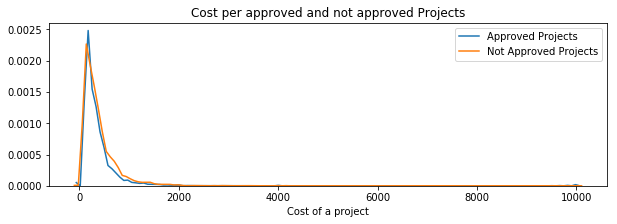

In [34]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [35]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

#### summary:
* Higher cost projects has more chance to be rejected
* Upper limit of project appears to be at 10000

### 2.2.9. Univariate Analysis: teacher_number_of_previously_posted_projects

In [36]:
df = univariantPlotsPlotly(column1 = 'teacher_id',
                           title = 'Number of Projects Approved vs Rejected: teacher_id', top = True)
print(df.tail())

72168
72168
                                  pos  total       avg     npart
fa2f220b537e8653fb48878ebb38044d   44     44  1.000000  0.000403
1f64dcec848be8e95c4482cc845706b2   40     42  0.952381  0.000384
df8a4b7ad173b57f7ac52e447cc24043   40     42  0.952381  0.000384
7b17c95da53e3d1f011f84232ad01238   34     34  1.000000  0.000311
ae67d8bbc64ec3bf7fd2db1297721160   31     33  0.939394  0.000302


                                  pos  total  avg     npart
61fdee5b0c34ea70671f52b3c3a01b71    1      1  1.0  0.000009
61ff263134490840c2a7f3b11e21cf0e    1      1  1.0  0.000009
61ff51943e34dba224a319b49a4d44fa    0      1  0.0  0.000009
61ff58caffe3bfef6e929db19e808aeb    1      1  1.0  0.000009
ffff8e040521f62207881376ecc964d5    1      1  1.0  0.000009


In [37]:
print(type(df))
df2 = df
print(df2.head())
totalCount = df2.loc[df2['total'] == 1].count().total
totalPos = df2.loc[(df2['total'] == 1) & (df2['pos'] == 1)].count().pos
print(totalCount)
print(totalPos)

percentage = totalPos / totalCount

print(percentage)

<class 'pandas.core.frame.DataFrame'>
                                  pos  total       avg     npart
fa2f220b537e8653fb48878ebb38044d   44     44  1.000000  0.000403
1f64dcec848be8e95c4482cc845706b2   40     42  0.952381  0.000384
df8a4b7ad173b57f7ac52e447cc24043   40     42  0.952381  0.000384
7b17c95da53e3d1f011f84232ad01238   34     34  1.000000  0.000311
ae67d8bbc64ec3bf7fd2db1297721160   31     33  0.939394  0.000302
54429
45002
0.8268018886990391


### summary:
* Very few teachers proposed more than 20 projects.
* Project approval rate vs submitted by teacher data is varying a lot
* 82% of the teachers who were first timers were accepted, that means first timers were given good chance.

### 2.2.10. Univariate Analysis: project_resource_summary

In [38]:
approved_summary_word_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
approved_sumary_word_count = approved_summary_word_count.values

rejected_summary_word_count = project_data[project_data['project_is_approved']==0]['project_resource_summary'].str.split().apply(len)
rejected_summary_word_count = rejected_summary_word_count.values

In [39]:
trace0 = go.Box(
    y = approved_sumary_word_count,
    name = 'approved',
    marker=dict(
        color='rgb(255,69,0)',
    ),
    boxmean='sd'
)
trace1 = go.Box(
    y = rejected_summary_word_count,
    name = 'rejected',
    marker=dict(
        color='rgb(10, 140, 208)',
    ),
    boxmean='sd'
)
data = [trace0, trace1]

layout = go.Layout(
        title = 'box plots for approved and rejected word counts of summary',
        yaxis = dict( title = 'number of words in summary')
    )
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [40]:
#creating numericCounter array value equal to 1 if summary has any numeric value otherwise 0.
numericCounter = []
import re
for i in list(project_data['project_resource_summary']):
    regexp = re.compile(r'[0-9]')
    if regexp.search(i):
        numericCounter.append(1)
    else:
        numericCounter.append(0)

project_data['numeric_counter'] = numericCounter# adding extra column to the data frame 

df = univariantPlotsPlotly('numeric_counter', title = 'approved vs rejected for numeric digits present in summary')

2
2
     pos  total       avg     npart
0  78616  93492  0.840885  0.855778
1  14090  15756  0.894263  0.144222


### summary:
* Almost 85% of projecting had no numeric charecter in its summary were accepted.
* though close to 90% of summaries having numeric charecter were accepted, but number of summaries haivng numeric charecter were significantly lesser than summaries having non numeric char.

## 2.3. Text Processing



#### Text Pre Processing Process:
1. Begin by removing html tags
2. remove punctuation marks and other marks
3. check if word is made up of english letters and is not aplha-nummeric,check to see if length of word is grater than two
4. convert the word to lowercase.
5. remove stopwords
6. Finally snowball stemming/potter stemming

### 2.3.1. Essay Text

In [41]:
project_data.head(2)

Unnamed: 0       id       ...       quantity numeric_counter
0      160221  p253737       ...             23               0
1      140945  p258326       ...              1               0

[2 rows x 23 columns]

In [42]:
# printing some random essays.
#https://www.geeksforgeeks.org/python-pandas-dataframe-values/
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [43]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [44]:
sent = decontracted(project_data['essay'].values[20000]) #take one essay
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [45]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [46]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [47]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [48]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:16<00:00, 1422.43it/s]


In [49]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

### 2.3.2 Project title Text****

In [50]:
# printing some random essays.
#https://www.geeksforgeeks.org/python-pandas-dataframe-values/
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[99999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Minds by Enhancing the Educational Experience


In [51]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 31597.31it/s]


In [52]:
# after preprocesing
preprocessed_titles[20000]

'we need to move it while we input it'

## 2.4. Preparing Data for models

In [53]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'catogories', 'sub_catogories', 'essay', 'price', 'quantity',
       'numeric_counter'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 2.4.1. Vectorizing Categorical data

#### 2.4.1.1. One Hot Encode- Categories of Projects

In [54]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['catogories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['catogories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


#### 2.4.1.2. One Hot Encode: Sub Categories of projects


In [55]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['sub_catogories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['sub_catogories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


#### 2.4.1.3. One Hot Encode: states

In [56]:
my_counter = Counter()
for state in project_data['school_state'].values:
    my_counter.update(state.split())

In [57]:
school_state_cat_dict = dict(my_counter)
sorted_school_state_cat_dict = dict(sorted(school_state_cat_dict.items(), key=lambda kv: kv[1]))

In [58]:
## we use count vectorizer to convert the values into one hot encoded features

vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_categories_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding ",school_state_categories_one_hot.shape)

['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encoding  (109248, 51)


#### 2.4.1.4. One Hot Encode: teacher_prefix

In [59]:
project_data.teacher_prefix = project_data['teacher_prefix'].fillna('nan')# replace null values with nan
my_counter = Counter()
for teacher_prefix in project_data['teacher_prefix'].values:
    teacher_prefix = str(teacher_prefix)
    my_counter.update(teacher_prefix.split())

In [60]:

teacher_prefix_cat_dict = dict(my_counter)
sorted_teacher_prefix_cat_dict = dict(sorted(teacher_prefix_cat_dict.items(), key=lambda kv: kv[1]))
del sorted_teacher_prefix_cat_dict["nan"]
print(sorted_teacher_prefix_cat_dict)

{'Dr.': 13, 'Teacher': 2360, 'Mr.': 10648, 'Ms.': 38955, 'Mrs.': 57269}


In [61]:

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_categories_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)

['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encoding  (109248, 5)


#### 2.4.1.5. One Hot Encoding: project_grade_category

In [62]:
project_data.project_grade_category = project_data['project_grade_category'].fillna('na')# replace null values with na
my_counter = Counter()
for project_grade_category in project_data['project_grade_category'].values:
    project_grade_category = str(project_grade_category)
    my_counter.update(project_grade_category.split())

In [63]:

project_grade_category_cat_dict = dict(my_counter)
sorted_project_grade_category_cat_dict = dict(sorted(project_grade_category_cat_dict.items(), key=lambda kv: kv[1]))
del sorted_project_grade_category_cat_dict["Grades"]
print(sorted_project_grade_category_cat_dict)

{'9-12': 10963, '6-8': 16923, '3-5': 37137, 'PreK-2': 44225}


In [64]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_categories_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding ",project_grade_categories_one_hot.shape)

['9-12', '6-8', '3-5', 'PreK-2']
Shape of matrix after one hot encoding  (109248, 4)


### 2.4.2. Vectorizing Text data

#### 2.4.2.1 Bag of words on `essays`

#### Bag of Words Process:
1. Construct a dictionary with unique words
2. constrcut a vector of dimenstion d(where d is equal to number of unique words)
3. assign weightage to each dimension.****

In [65]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
vectorizer = CountVectorizer(min_df=10)#min_df = 10 ignore the words which appear in less than 10 documents
text_bow_essays = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow_essays.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 2.4.2.2 Bag of Words on `project_title`

In [66]:
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
vectorizer = CountVectorizer(min_df=10)#min_df = 10 ignore the words which appear in less than 10 documents
text_bow_project_titles = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",text_bow_project_titles.shape)

Shape of matrix after one hot encodig  (109248, 3329)


## summary:
* `essays` has 16623 unique words, ignoring the words which are in less than 10 documents
* `project_title` has 3329 unique words, ignoring the words which are in less than 10 documents

#### 2.4.2.3 TFIDF vectorizer `preprocessed_essays` 

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_essays = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf_essays.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.4 TFIDF Vectorizer on `project_title`

In [68]:
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_titles = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",text_tfidf_titles.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 2.4.2.5 Using Pretrained Models: Avg W2V

In [69]:

# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    '''
    here create a dictionary of words with it vector as value
    '''
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    f.close()
    return model






In [70]:
model = loadGloveModel('../input/glovedataset/glove.42B.300d.txt')

856it [00:00, 8555.03it/s]

Loading Glove Model


1917495it [04:10, 7661.18it/s]

Done. 1917495  words loaded!


In [71]:
words = []
for i in tqdm(preprocessed_essays):
    words.extend(i.split(' '))

for i in tqdm(preprocessed_titles):
    words.extend(i.split(' '))
print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in tqdm(words):
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: 
#http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

100%|██████████| 58968/58968 [00:00<00:00, 493947.16it/s]


all the words in the corpus 17014413
the unique words in the corpus 58968
The number of words that are present in both glove vectors and our coupus 51503 ( 87.341 %)
word 2 vec length 51503


In [72]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [73]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:45<00:00, 2412.29it/s]

109248
300


#### 2.4.2.6 Using Pretrained Models: AVG W2V on `project_title`

In [74]:
avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:02<00:00, 49006.79it/s]

109248
300


#### 2.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [75]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [76]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [04:26<00:00, 410.31it/s]

109248
300


#### 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on `project_title`

In [77]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [78]:
# average Word2Vec
# compute average word2vec for each Project Title
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)

print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))

100%|██████████| 109248/109248 [00:05<00:00, 18963.40it/s]

109248
300


### 2.4.3 Vectorizing Numerical features

# Vectorizing - Price (Numerical Data)

In [79]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))
# Now standardize the data with above mean and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608
Standard deviation : 367.49634838483496


In [80]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

#### summary:
* Mean of data set is 298.12 dollars
* standard deviation stood at 367.5 dollars
* Most frequent requirements are under 1000 dollars.

# Vectorizing - Quantity (Numerical Data)

In [81]:
quantity_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1)) 

print("Mean : {}".format(quantity_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(quantity_scalar.var_[0])))

# Now standardize the data with above mean and variance.
quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964
Standard deviation : 26.182821919093175


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [82]:
quantity_standardized

array([[ 0.23047132],
       [-0.60977424],
       [ 0.19227834],
       ...,
       [-0.4951953 ],
       [-0.03687954],
       [-0.45700232]])

In [83]:
quantity_standardized.shape

(109248, 1)

# Vectorizing - Number of Projects Proposed Previously by the Teacher (Numerical Data)

In [84]:
prev_projects_scalar = StandardScaler()

## Finding the mean and standard deviation of this data
prev_projects_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 

print("Mean : {}".format(prev_projects_scalar.mean_[0]))

print("Standard deviation : {}".format(np.sqrt(prev_projects_scalar.var_[0])))

# Now standardize the data with above maen and variance.
prev_projects_standardized = prev_projects_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848
Standard deviation : 27.77702641477403


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [85]:

prev_projects_standardized

array([[-0.40152481],
       [-0.14951799],
       [-0.36552384],
       ...,
       [-0.29352189],
       [-0.40152481],
       [-0.40152481]])

In [86]:
prev_projects_standardized.shape

(109248, 1)

### summary:
* As we saw in box plot there are more than 80 percentage of pprojects were proposed by new comers
* Since mean stood at 11 we can say for a given year, there are numerous cases where a teachers proposed more than 1 project

### 2.4.4 Merging all the above features
* we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [87]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow_essays.shape)
print(price_standardized.shape)


(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [88]:

# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow_essays, price_standardized))
X.shape

(109248, 16663)

# TSNE with `BOW` encoding of `project_title` feature (5000 Data Entries)

In [89]:

x = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot,
            price_standardized, quantity_standardized, prev_projects_standardized,text_bow_project_titles))
#x.shape
print(text_bow_project_titles.shape)
x = x.tocsr()
print(x.shape)

(109248, 3329)
(109248, 3431)


<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



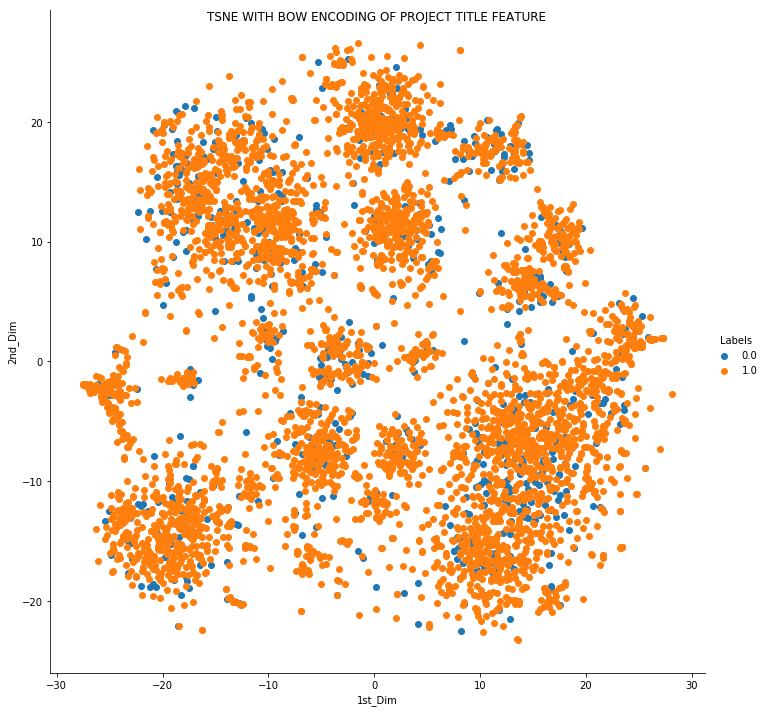

In [90]:
from sklearn.manifold import TSNE
X_new = x.toarray()
model = TSNE(n_components = 2, perplexity = 100.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new[0:5000,:])
labels = project_data["project_is_approved"]
print(type(labels))
labels= labels[0:5000]
len(labels)
tsne_data_b = np.vstack((tsne_data_b.T, labels)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

#### summary:
* There are some clusters of data but there is severe overlapping
* Tried for different perplexities from  30 to 100 but it seeems data is not forming any pattern, there is nothing much we could learn from this tsne

# TSNE with `Tf-Idf` encoding of `project_title` feature (5000 Data Entries)

In [91]:
del model
x = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot,
            price_standardized, quantity_standardized, prev_projects_standardized,text_tfidf_titles))
#x.shape
x = x.tocsr()
print(x.shape)

(109248, 3431)


In [92]:
text_tfidf_titles.shape

(109248, 3329)

In [93]:
X_new = x.toarray()
model = TSNE(n_components = 2, perplexity = 30.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new[0:5000,:])
print(type(labels))

<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



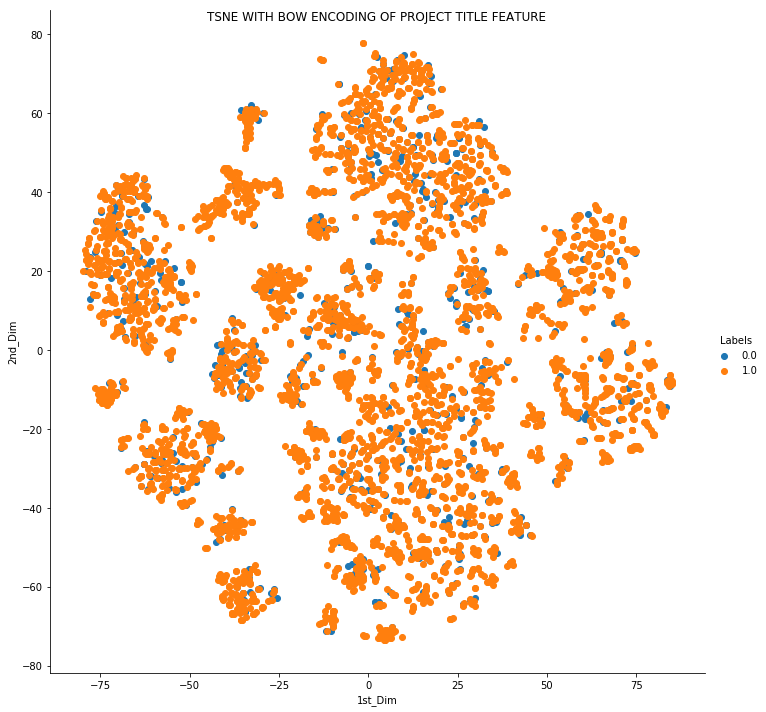

In [94]:
tsne_data_b = np.vstack((tsne_data_b.T, labels)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

#### summary:
* There are some clusters of data but there is severe overlapping
* Tried for different perplexities from  30 to 100 but it seeems data is not forming any pattern, there is nothing much we could learn from this tsne

# TSNE with `avg W2V` encoding of `project_title` feature (5000 Data Entries)[](http://)

In [95]:
del model
x = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot,
            price_standardized, quantity_standardized, prev_projects_standardized,avg_w2v_vectors_titles))
#x.shape
x = x.tocsr()
print(x.shape)

(109248, 402)


In [96]:
X_new = x.toarray()
model = TSNE(n_components = 2, perplexity = 50.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new[0:5000,:])
print(type(labels))

<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



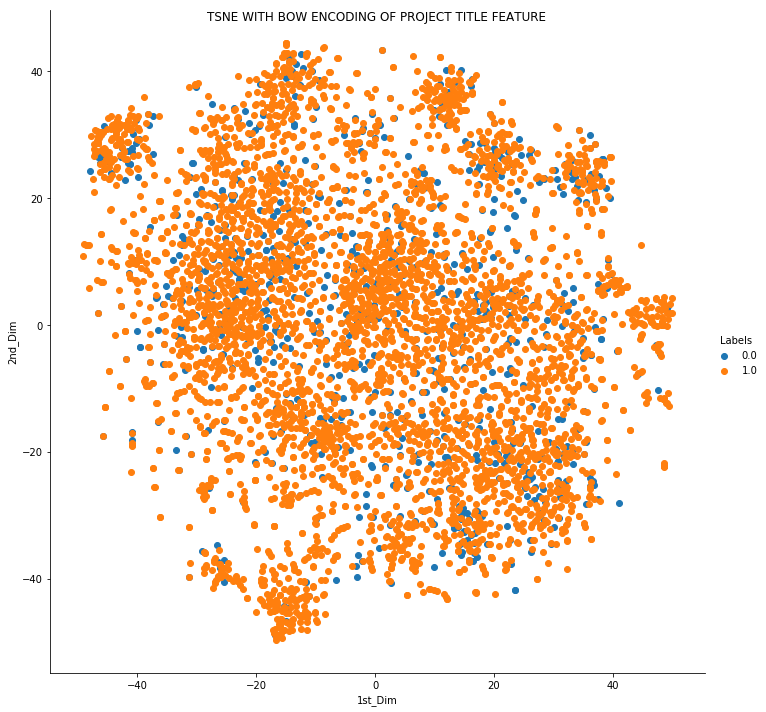

In [97]:
tsne_data_b = np.vstack((tsne_data_b.T, labels)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

#### summary:
* There are some clusters of data but there is severe overlapping
* Tried for different perplexities from  30 to 100 but it seeems data is not forming any pattern, there is nothing much we could learn from this tsne

# TSNE with `Tf-Idf W2V` encoding of `project_title` feature (5000 Data Entries)

In [98]:
X_new = x.toarray()
model = TSNE(n_components = 2, perplexity = 30.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new[0:5000,:])
print(type(labels))

<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



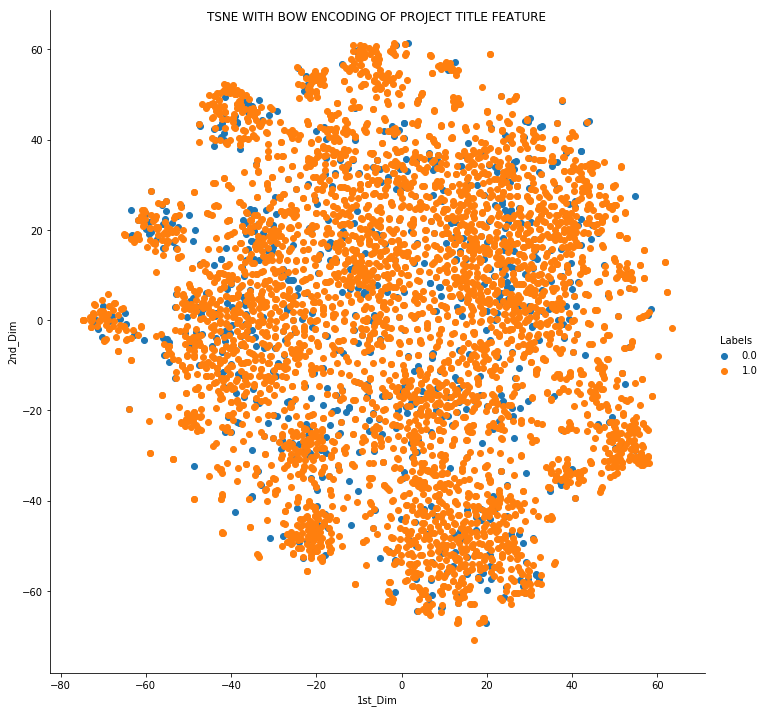

In [99]:
tsne_data_b = np.vstack((tsne_data_b.T, labels)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

#### summary:
* There are some clusters of data but there is severe overlapping
* Tried for different perplexities from  30 to 100 but it seeems data is not forming any pattern, there is nothing much we could learn from this tsne

# TSNE with all text Vector encoding of `project_title` feature along with numeric and categorical vectors(5000 Data Entries)

In [100]:
del model
x = hstack((categories_one_hot, sub_categories_one_hot, school_state_categories_one_hot,
            project_grade_categories_one_hot, teacher_prefix_categories_one_hot,
            price_standardized, quantity_standardized, prev_projects_standardized,tfidf_w2v_vectors_title,
            avg_w2v_vectors_titles,text_tfidf_titles,text_bow_project_titles))
#x.shape
x = x.tocsr()
print(x.shape)

(109248, 7360)


In [101]:
X_new = x.toarray()
model = TSNE(n_components = 2, perplexity = 50.0, random_state = 0)
tsne_data_b = model.fit_transform(X_new[0:5000,:])
print(type(labels))

<class 'pandas.core.series.Series'>


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



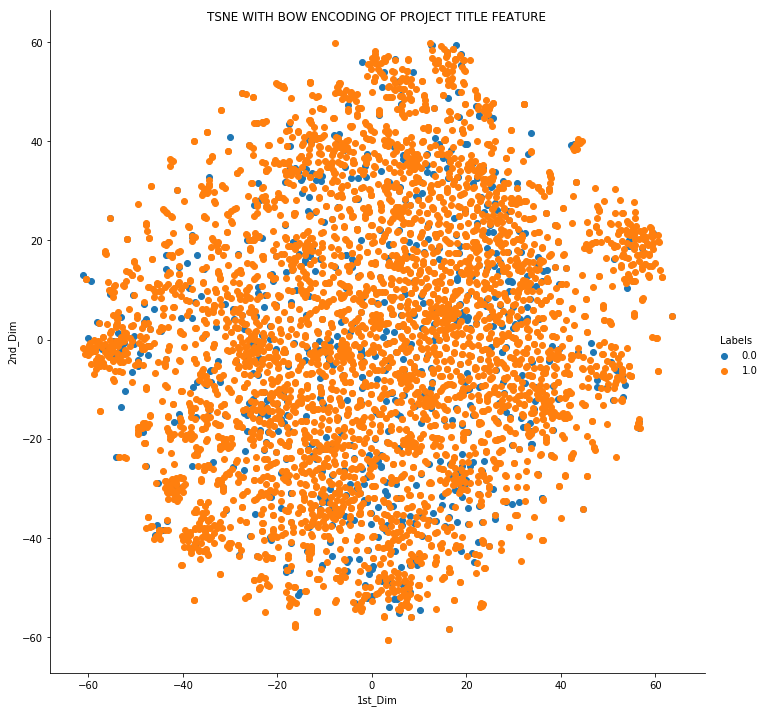

In [102]:
tsne_data_b = np.vstack((tsne_data_b.T, labels)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
tsne_df_b.shape
sns.FacetGrid(tsne_df_b, hue = "Labels", size = 10).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE WITH BOW ENCODING OF PROJECT TITLE FEATURE ")
plt.show()

#### summary:
* There are some clusters of data but there is severe overlapping
* Tried for different perplexities from  30 to 100 but it seeems data is not forming any pattern, there is nothing much we could learn from this tsne

# Summary:

* Data Under consideration has 109248 proposals or points
* given data set seems clean and no duplicates found
* close to 85 percentage of projects were approved that means a project proposed has more chance of approval or donorchoose try to approve as many projects as possible
* Number of female who submitted a project are very high compared to other genderes
* Eventhough Highest rate of approval is for female gender there is not much significant difference in approval rate, But data tells female teachers try better than male in bettering the life of students
*  CA state topped the list of registered projects but there is no state wise biase in approval atleast data tells there is no siginificant in approval rate between sates
* Lower the grade higher is the chance of projects submission, that means pre school and elementary schools puppil are benifitting more from donations, but this onservation tells than there may be chance that for higher education student, the cost per project may be high and hence teachers might be reluctant to propose a project.But, there is no bise in approving pojects against grades 
* literacy language category has more number of submissions, from both number of projects by grade and category of submission it obvious that since pre-school and lower school students need to learn more language understanding the number of projects on the literacy and pre school are high
* One Interesting observation is if tagged categories or tagged sub catefories are mismatching then there is more change of project to be rejected.
* Most number of projects have titles between  3 and 6 words
* On an average rejected has lesser number of words than accepted, but both rejected and approved has huge area of overlap that we can't really conclude any relationship between number of words and approval status.
* both approved and rejected word count for essays does not have pattern to categorise but on an average approved projects has more number of projects
* Higher cost projects has more chance of being rejected. On average a good projects are at around 200 dollars
* 82% of the teachers who were first timers were accepted, that means first timers were given good chance.
* though close to 90% of summaries having numeric charecter were accepted, but number of summaries haivng numeric charecter were significantly lesser than summaries having non numeric char.
* Visualisation of TSNE with Bag of Words, TF-IDF, Avg Word2Vec, TF-IDF Weighted Word2Vec does not seem to yield the expected result of clustering similar data points. Hence we would have to try any other method.

